In [5]:
%%time
import pandas as pd
df = pd.read_csv("Final Model\HMAHCC_COMP.csv")

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)

<string>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 30.7 s


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Look at opioid treatment

In [7]:
rx_paid = df[df['event_descr']=='RX Claim - Paid']

rx_paid = rx_paid.drop(['event_attr2',
                        'event_attr7'],
                         axis = 1)

rx_paid.columns = ['id',
                   'event_descr',
                   'gpi_drug_class_description',
                   'rx_cost',
                   'net_paid_amount',
                   'brand_name',
                   'drug_group_description',
                   'generic_name',
                   'member_responsible_amount',
                   'gpi_drug_group8_id',
                   'Days',
                   'PAY_DAY_SUPPLY_CNT',
                   'PAYABLE_QTY',
                   'MME',
                   'DRUG_TYPE',
                   'Specialty',
                   'Specialty2',
                   'Specialty3']

In [8]:
response_variable = pd.read_csv('response_variable_v2.csv')
response_variable = response_variable.dropna()
response_variable = response_variable.set_index('id')

In [9]:
LTOT_list = response_variable.index.values

## METHADONE

In [10]:
mask = rx_paid['generic_name'].map(lambda x: 'METHADONE' in str(x)) 
METHADONE = rx_paid[mask]
np.sum(METHADONE['id'].drop_duplicates().map(lambda x: x in LTOT_list))/7000 # about 50% of 14000 people in sample

0.031142857142857142

## METHADONE: Annual Expense (Humana's cost) per patient

In [11]:
mask = rx_paid['generic_name'].map(lambda x: 'METHADONE' in str(x))&(rx_paid['Days'] >=180)&(rx_paid['Days'] <=(365+180)) 
METHADONE = rx_paid[mask]
METHADONE_ppl = np.sum(METHADONE['id'].drop_duplicates().map(lambda x: x in LTOT_list))
np.sum(METHADONE['net_paid_amount'].map(float))/METHADONE_ppl

57.65379310344828

## BUPRENORPHINE

In [12]:
mask = rx_paid['generic_name'].map(lambda x: 'BUPRENORPHINE' in str(x)) 
BUPRENORPHINE = rx_paid[mask]
np.sum(BUPRENORPHINE['id'].drop_duplicates().map(lambda x: x in LTOT_list))/7000 # about 50% of 14000 people in sample

0.027142857142857142

## BUPRENORPHINE: Annual Expense (Humana's cost) per patient

In [13]:
mask = rx_paid['generic_name'].map(lambda x: 'BUPRENORPHINE' in str(x))&(rx_paid['Days'] >=180)&(rx_paid['Days'] <=(365+180)) 
BUPRENORPHINE = rx_paid[mask]
BUPRENORPHINE_ppl = np.sum(METHADONE['id'].drop_duplicates().map(lambda x: x in LTOT_list))
np.sum(BUPRENORPHINE['net_paid_amount'].map(float))/BUPRENORPHINE_ppl

698.4008620689655

## NALTREXONE

In [14]:
mask = rx_paid['generic_name'].map(lambda x: 'NALTREXONE' in str(x)) 
NALTREXONE = rx_paid[mask]
np.sum(NALTREXONE['id'].drop_duplicates().map(lambda x: x in LTOT_list))/7000 # about 50% of 14000 people in sample

0.01657142857142857

## NALTREXONE: Annual Expense (Humana's cost) per patient

In [15]:
mask = rx_paid['generic_name'].map(lambda x: 'NALTREXONE' in str(x))&(rx_paid['Days'] >=180)&(rx_paid['Days'] <=(365+180)) 
NALTREXONE = rx_paid[mask]
NALTREXONE_ppl = np.sum(METHADONE['id'].drop_duplicates().map(lambda x: x in LTOT_list))
np.sum(NALTREXONE['net_paid_amount'].map(float))/NALTREXONE_ppl

661.4903448275862

### Goal: reduce LTOTs
#### What is the benefits of lowering LTOTs?
1. Save people's lives and their families.

2. Cost-saving: We can save 2.8 million on opioid cost if we decrease LTOT probability by 10%. Note that here we only consider the saving on opioid drugs, and there are more cost-saving potential if we take account of other meditation costs associating with opioid prescriptions. [See analysis below]

3. Brand image: the effort to reducing LTOLs is also favorable to Humana's brand image.

In [16]:
rx_paid = df[df['event_descr']=='RX Claim - Paid']

rx_paid = rx_paid.drop(['event_attr2',
                        'event_attr7'],
                         axis = 1)

rx_paid.columns = ['id',
                   'event_descr',
                   'gpi_drug_class_description',
                   'rx_cost',
                   'net_paid_amount',
                   'brand_name',
                   'drug_group_description',
                   'generic_name',
                   'member_responsible_amount',
                   'gpi_drug_group8_id',
                   'Days',
                   'PAY_DAY_SUPPLY_CNT',
                   'PAYABLE_QTY',
                   'MME',
                   'DRUG_TYPE',
                   'Specialty',
                   'Specialty2',
                   'Specialty3']

day_mask = (rx_paid['Days'] >=180)&(rx_paid['Days'] <=(365+180)) 
df2 = rx_paid[day_mask]

df2 = df2[df2['PAY_DAY_SUPPLY_CNT'].notnull()]
df2.loc[:,'net_paid_amount']  = df2['net_paid_amount'].map(lambda x: float(x))

total_costs = df2.groupby(by=['id'])['net_paid_amount'].sum()
total_costs = pd.DataFrame(total_costs)

response_variable = pd.read_csv('response_variable_v2.csv')
response_variable = response_variable.dropna()
response_variable = response_variable.set_index('id')

df3 = pd.concat([response_variable[['LTOT_v2']], total_costs], 
                axis=1, join='inner')

opioid_costs_table = df3.groupby(by=['LTOT_v2'])['net_paid_amount'].mean()

In [17]:
tmp = pd.DataFrame(opioid_costs_table)
tmp.index = ['non-LTOTs', 'LTOTs']
tmp.columns = ['Average opioid costs per patient per year']
tmp.T

,non-LTOTs,LTOTs
Average opioid costs per patient per year,26.349009,190.555065


In [18]:
Humana_member = 16600000 # as of June 2019
LTOT_rate = 0.0104  
LTOT_extra_opioid_costs = (opioid_costs_table[True] - opioid_costs_table[False])
decrease_LTOT_probability = 0.1

# Opioid costs saving = 
Humana_member * LTOT_rate * LTOT_extra_opioid_costs * decrease_LTOT_probability

2834853.3524969923

If you decrease prabability of LTOT's by 10%, you can save 2.8 million of costs on opioid drugs (there are more to save: need some brainstorm here about what other possible costs related to LTOTs)

### Recommendation: to reduce LTOTs, we recommend introducing our model into doctors' decision-making process

#### Why do we recommend that?
1. Based on our analysis, the period (SUPPLY_CNT) of the opioid prescription on day 0 contributed the most to LTOTs. And time span of the prescription is based on doctors' knowledge and the communication between doctors and patients. 

2. Our model could provide critical information: the probability of becoming LTOTs given the patient's medical history and the anticipated opioid prescription at the moment. With this information, we believe doctors can better communicate with patients, and they can better assess the risks of using opioids and eventually choose a more appropriate dose.

3. Based on our analysis, a 27% decrease in SUPPLY_CNT can lead a 10% reduction in the probability of becoming LTOTs. [See analysis below]

C:\Users\cgn31\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


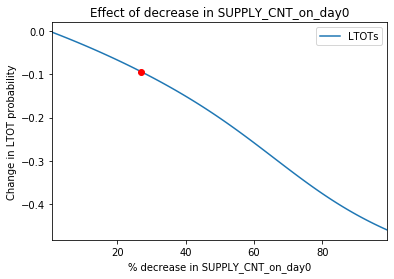

In [20]:
features3 = pd.read_csv('features_matthew_v2.csv')
features3 = features3.set_index('key_0')
features_matthew_v2 = features3.copy()

df2= pd.concat([response_variable[['LTOT_v2']], features_matthew_v2], 
                axis=1, join='inner')
df2=df2.fillna(0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = df2.iloc[:,1:10]
y = df2.iloc[:,0].map(lambda x: 1 if x == True else 0 )

logit_model = LogisticRegression()
logit_model.fit(X, y)
prediction_on_X_train = logit_model.predict_proba(X)

check = pd.DataFrame(y).copy()
check['pred_proba'] = prediction_on_X_train[:,1]
mean_proba_nonLTOT = check.groupby(by=['LTOT_v2'])['pred_proba'].mean()[0]
mean_proba_LTOT = check.groupby(by=['LTOT_v2'])['pred_proba'].mean()[1]

final_output = pd.DataFrame()
for decrease in range(1,100):
    X2 = X.copy()
    X2['SUPPLY_CNT_on_day0'] = X2['SUPPLY_CNT_on_day0']*(100-decrease)/100    
    prediction_on_X_test = logit_model.predict_proba(X2)    
    check = pd.DataFrame(y).copy()
    check['pred_proba'] = prediction_on_X_test[:,1]
    output = pd.DataFrame(check.groupby(by=['LTOT_v2'])['pred_proba'].mean()).T
    output.index = [decrease]
    final_output = final_output.append(output, sort=False)

final_output[0] = final_output[0] - mean_proba_nonLTOT
final_output[1] = final_output[1] - mean_proba_LTOT
final_output.columns = ['non_LTOTs', 'LTOTs']
final_output['LTOTs'].plot()
plt.title('Effect of decrease in SUPPLY_CNT_on_day0')
plt.xlabel('% decrease in SUPPLY_CNT_on_day0')
plt.ylabel('Change in LTOT probability')
target_x = final_output.index[26] # when y is around -0.1 
target_y = final_output.iloc[26,1]
plt.plot(target_x, target_y, 'o', color = 'r')
plt.savefig('decrease_sc.png',dpi=750)
plt.legend()

To estimate the affect of decrease in SUPPLY_CNT_on_day0. We ran logistic Regressin model on modified training data where we graduatly decreased the feature SUPPLY_CNY_on_day0. The line in the chart shows how much we can reduce LTOT probability by decreasing SUPPLY_CNT_on_day0, while the red point shows 27% decrease in **SUPPLY_CNT_on_day0 can lead 10% reduction in probability of becoming LTOTs.**  

#### Actionable Steps:
1. Start small, work with one hospital, build a program/app that shows the probability of patients becoming LTOTs whenever doctors intend to prescribe opioids.  **add time needed to make one prediction**

2. At this point, we can also leverage this effort to gain press exposure and build an image of trying to do good to the society.

3. Keep tracking these patients for one year. Test if the number of new LTOTs decreased comparing to historical data.

4. Expand to other hospitals.


#### Risks/ future analysis
1. Regulation: need to consult lawyers to determine an illegible way to incorporate the model into a doctor's decision process. While further legal clarification is required,  we believe the risk is limited as our model does not discriminate against personal identities.

2. Better model: we can incorporate data after day 0 into the model and further strengthen the prediction power.

#### ====================================================================

# Feature Engineering Process

### Preliminary Research
In the preliminary research stage (reference listed below), we tried to understand the mechanism of addiction to opioids. Based on our research, we formed a set of hypotheses: the opioid addiction is connected with the strength of the medication, the length of prescriptions of opioids, and the reason for being prescripted with opioids. Following, we conducted exploratory analysis on the data to test the hypotheses. 


Reference list
1. This Is What fHappens to Your Brain on Opioids | Short Film Showcase: https://www.youtube.com/watch?v=NDVV_M__CSI&list=PLDdKnevXXDUx5G3fqp8YulApUZa-oeFxK&index=2&t=0s
2. The Science of Opioid Addiction and Treatment: https://www.youtube.com/watch?v=0Gnj-DKlbd4&list=PLDdKnevXXDUx5G3fqp8YulApUZa-oeFxK&index=3
3. How opioids are best used for pain management: https://www.youtube.com/watch?v=nyuZMFXzzvo
4. Side effects of opioids, particularly addiction: https://www.youtube.com/watch?v=ypw1EBx95TA
5. edX course "The Opioid Crisis in America": https://www.edx.org/course/the-opioid-crisis-in-america-2 

### Hypotheses testing
#### 1. Strength of the medication: the stronger drug used, the more likely to become LTOT 
We take HYDROCODONE-ACETAMINOPHEN as an example, the most used opioid drug in this dataset, as an example. The number denoted at the end of drug names indicated its strength. For example, 5-325 MG is the weakest type, and 10-325 MG means the strongest type for this medication. As shown in the table below, 70% of patients who took the strongest type medication on day 0 became LTOTs, and only 34% of patients who took the least strong type of drug became LTOTs. Thus, we conclude people who take stronger drugs are more likely to become LTOTs. 

In [22]:
test1.loc[['HYDROCODONE-ACETAMINOPHEN TAB 5-325 MG', 'HYDROCODONE-ACETAMINOPHEN TAB 7.5-325 MG', 'HYDROCODONE-ACETAMINOPHEN TAB 10-325 MG']]

,Not LTOT,of LTOT
HYDROCODONE-ACETAMINOPHEN TAB 5-325 MG,0.670743,0.329257
HYDROCODONE-ACETAMINOPHEN TAB 7.5-325 MG,0.537375,0.462625
HYDROCODONE-ACETAMINOPHEN TAB 10-325 MG,0.297368,0.702632


#### 2. Length of prescriptions: the longer a patien takes opioid, the more likely to become LTOT
Here we looke at the PAY_DAY_SUPPLY_CNT on day 0, because PAY_DAY_SUPPLY_CNT means the the number of days a patient takes opioid drugs. As shown in the table below, around 93% of patients with high SUPPLY_CNT_level, which means PAY_DAY_SUPPLY_CNT is greater than 30, became LTOTs. Vice versa, only 18% in low SUPPLY_CNT_level group became LTOTs. Therefore, we conclude that the length of prescriptions is an important indicator to LTOTs.

In [64]:
test2.index.name = 'SUPPLY_CNT_level'
test2

,Not LTOT,of LTOT
SUPPLY_CNT_level,,
low,0.813788,0.186212
medium_low,0.681524,0.318476
medium_high,0.225567,0.774433
high,0.072139,0.927861


low: (0.999, 5.0]
medium_low: (5.0, 15.0]
medium_high: (15.0, 30.0]
high: (30.0, 90.0]

#### ===================================================================================

## Below are some exploratory analysis, please ignore for now

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


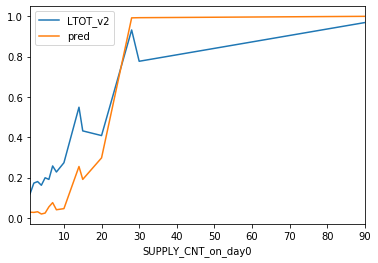

In [263]:
check['pred_proba'] = prediction_on_X_train[:,1]
check['SUPPLY_CNT_on_day0'] = X['SUPPLY_CNT_on_day0']
check['pred'] = logit_model.predict(X)
# check.sort_values(['SUPPLY_CNT_on_day0'], ascending=False)

test = check.groupby(by=['SUPPLY_CNT_on_day0'])['LTOT_v2', 'pred'].mean().sort_index(ascending =False)
mask = check['SUPPLY_CNT_on_day0'].value_counts() > 100
test[mask].plot()

## the following are codes ==============
## no content below ===================

In [3]:
rx_paid = df[df['event_descr']=='RX Claim - Paid']

rx_paid = rx_paid.drop(['event_attr2',
                        'event_attr7'],
                         axis = 1)

rx_paid.columns = ['id',
                   'event_descr',
                   'gpi_drug_class_description',
                   'rx_cost',
                   'net_paid_amount',
                   'brand_name',
                   'drug_group_description',
                   'generic_name',
                   'member_responsible_amount',
                   'gpi_drug_group8_id',
                   'Days',
                   'PAY_DAY_SUPPLY_CNT',
                   'PAYABLE_QTY',
                   'MME',
                   'DRUG_TYPE',
                   'Specialty',
                   'Specialty2',
                   'Specialty3']

In [3]:
# read in response_variable
response_variable = pd.read_csv('response_variable.csv')
response_variable = response_variable.iloc[:,:2]
response_variable.head()

,id,LTOT
0,ID10010854159,False
1,ID10013863216,True
2,ID10024447278,True
3,ID1002482139,True
4,ID1003386406,False


In [4]:
opioid_col = ['id',
              'gpi_drug_class_description',
              'brand_name',
              'drug_group_description',
              'generic_name',
              'gpi_drug_group8_id',
              'PAY_DAY_SUPPLY_CNT',
              'Specialty',
              'Specialty2',
              'Specialty3',
              'Days']

opioid = rx_paid[ (rx_paid['PAY_DAY_SUPPLY_CNT'].notnull())][opioid_col]

#### Code to get first table

In [24]:
HYD = opioid[ (opioid['brand_name'] == 'HYDROCODONE/ACETAMINOPHEN') & (opioid['Days'] == 0)]
HYD2 = pd.merge(HYD, response_variable, on = 'id')
test1 = (HYD2.groupby(by=['generic_name', 'LTOT'])['LTOT'].count().unstack().T/HYD['generic_name'].value_counts()).T
test1.columns = ['Not LTOT', 'of LTOT']
test1.loc[['HYDROCODONE-ACETAMINOPHEN TAB 5-325 MG', 'HYDROCODONE-ACETAMINOPHEN TAB 7.5-325 MG', 'HYDROCODONE-ACETAMINOPHEN TAB 10-325 MG']]

,Not LTOT,of LTOT
HYDROCODONE-ACETAMINOPHEN TAB 5-325 MG,0.670743,0.329257
HYDROCODONE-ACETAMINOPHEN TAB 7.5-325 MG,0.537375,0.462625
HYDROCODONE-ACETAMINOPHEN TAB 10-325 MG,0.297368,0.702632


#### Code to get second table: SUPPLY_CNT and LTOTs

In [57]:
tmp = opioid[ (opioid['PAY_DAY_SUPPLY_CNT'].notnull()) & (opioid['Days'] == 0)]
tmp = tmp.groupby(by=['id'])['PAY_DAY_SUPPLY_CNT'].max()
tmp = pd.merge(tmp, response_variable, on = 'id')
tmp['Supply_CNY_level'] = pd.qcut(tmp['PAY_DAY_SUPPLY_CNT'], 4, labels=['low','medium_low','medium_high','high'])

In [62]:
test2 = (tmp.groupby(by=['Supply_CNY_level', 'LTOT'])['LTOT'].count().unstack().T/tmp['Supply_CNY_level'].value_counts()).T
test2 = test2.loc[['low','medium_low','medium_high','high'],:]
test2.columns = ['Not LTOT', 'of LTOT']
test2

,Not LTOT,of LTOT
low,0.813788,0.186212
medium_low,0.681524,0.318476
medium_high,0.225567,0.774433
high,0.072139,0.927861


In [56]:
pd.qcut(tmp['PAY_DAY_SUPPLY_CNT'], 4)

0        (0.999, 5.0]
1        (30.0, 90.0]
2        (0.999, 5.0]
3        (15.0, 30.0]
4         (5.0, 15.0]
5        (0.999, 5.0]
6        (0.999, 5.0]
7        (0.999, 5.0]
8        (0.999, 5.0]
9        (0.999, 5.0]
10       (0.999, 5.0]
11       (0.999, 5.0]
12       (15.0, 30.0]
13       (15.0, 30.0]
14       (0.999, 5.0]
15       (30.0, 90.0]
16       (15.0, 30.0]
17        (5.0, 15.0]
18       (15.0, 30.0]
19       (15.0, 30.0]
20       (0.999, 5.0]
21       (0.999, 5.0]
22       (15.0, 30.0]
23       (0.999, 5.0]
24       (15.0, 30.0]
25       (30.0, 90.0]
26       (0.999, 5.0]
27       (0.999, 5.0]
28        (5.0, 15.0]
29       (15.0, 30.0]
30       (0.999, 5.0]
31       (15.0, 30.0]
32       (30.0, 90.0]
33        (5.0, 15.0]
34       (15.0, 30.0]
35       (30.0, 90.0]
36       (0.999, 5.0]
37       (15.0, 30.0]
38       (15.0, 30.0]
39       (0.999, 5.0]
40       (0.999, 5.0]
41       (0.999, 5.0]
42       (0.999, 5.0]
43       (15.0, 30.0]
44        (5.0, 15.0]
45       (